In [71]:
import os
import pickle
import numpy as np
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import pandas as pd
from ecgdetectors import Detectors
%matplotlib inline 

In [72]:
class read_data_of_one_subject:
    """Read data from WESAD dataset"""
    def __init__(self, path, subject):
        self.keys = ['label', 'subject', 'signal']
        self.signal_keys = ['wrist', 'chest']
        self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
        self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        #os.chdir(path)
        #os.chdir(subject)
        with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
            data = pickle.load(file, encoding='latin1')
        self.data = data

    def get_labels(self):
        return self.data[self.keys[0]]

    def get_wrist_data(self):
        """"""
        #label = self.data[self.keys[0]]
        assert subject == self.data[self.keys[1]]
        signal = self.data[self.keys[2]]
        wrist_data = signal[self.signal_keys[0]]
        #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
        #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
        return wrist_data

    def get_chest_data(self):
        """"""
        signal = self.data[self.keys[2]]
        chest_data = signal[self.signal_keys[1]]
        return chest_data


In [73]:
data_set_path = "C:/Users/Adnane/OneDrive - Delft University of Technology/Bureaublad/Nieuwe map/WESAD/WESAD/"
subject = 'S3'

In [74]:
# Object instantiation
obj_data = {}
 
# Accessing class attributes and method through objects
obj_data[subject] = read_data_of_one_subject(data_set_path, subject)

In [115]:
# read and print length of signal
chest_data_dict = obj_data[subject].get_chest_data()
chest_dict_length = {key: len(value) for key, value in chest_data_dict.items()}
print(chest_dict_length)

{'ACC': 4545100, 'ECG': 4545100, 'EMG': 4545100, 'EDA': 4545100, 'Temp': 4545100, 'Resp': 4545100}


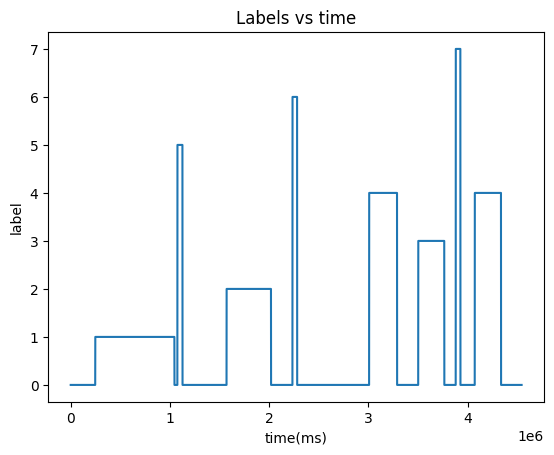

In [135]:
# Get labels
# 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset.
fs = 700
labels = obj_data[subject].get_labels()
baseline = np.asarray([idx for idx,val in enumerate(labels) if val == 1])
t=np.arange(0,labels.size*(1/fs),(1/fs))
t=t[:labels.size]
# plt.plot(t, labels)
plt.title('Labels vs time')
plt.ylabel('label')
plt.xlabel('time(ms)')
labels.shape

plt.plot(labels)

(798000,)


Text(0, 0.5, '$ECG$')

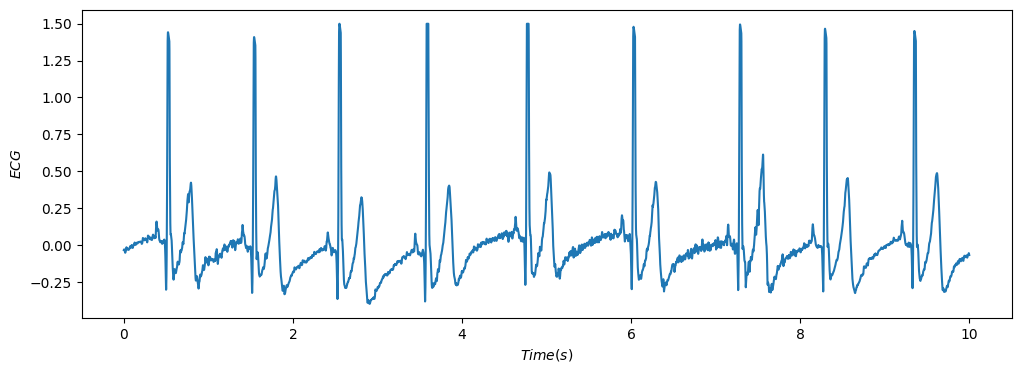

In [122]:
# load smaller part of recording
ecg_base=chest_data_dict['ECG'][baseline,0]
fs=700

# cut a smaller window
ecg=ecg_base[10000:10000+ 10*fs]
print(ecg_base.shape)
t=np.arange(0,ecg.size*(1/fs),(1/fs))
t=t[:ecg.size]

plt.figure(figsize=(12,4))
plt.plot(t,ecg)
plt.xlabel('$Time (s)$') 
plt.ylabel('$ECG$') 


Text(0, 0.5, '$ECG$')

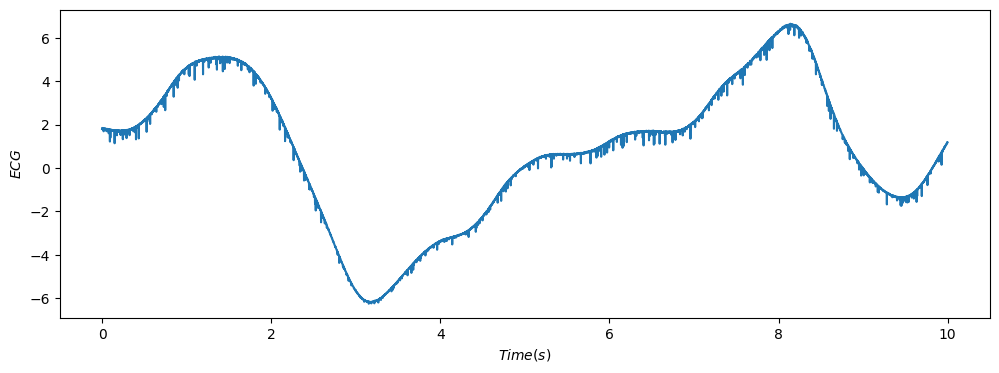

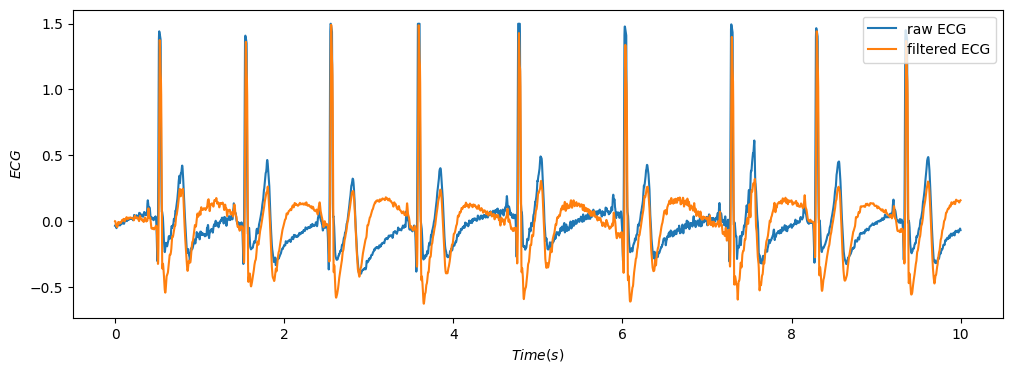

In [78]:
# filtering
nyq = 0.5*fs
order=5

# highpass filter
high=0.5
high= high/nyq
b, a = butter(order, high, 'highpass')
ecg_h = lfilter(b,a,ecg)

# lowpass filter
low = 70
low= low/nyq
b, a = butter(order, low, 'lowpass')
ecg_hl = lfilter(b,a,ecg_h)

# notch filter
notch=50
notch = notch/nyq
b, a = iirnotch(notch, 30, fs)
ecg_hln = lfilter(b,a,ecg_hl)


plt.figure(figsize=(12,4))
plt.plot(t,ecg,label="raw ECG")
plt.plot(t,ecg_hln, label="filtered ECG")
plt.xlabel('$Time (s)$') 
plt.ylabel('$ECG$') 
plt.legend()

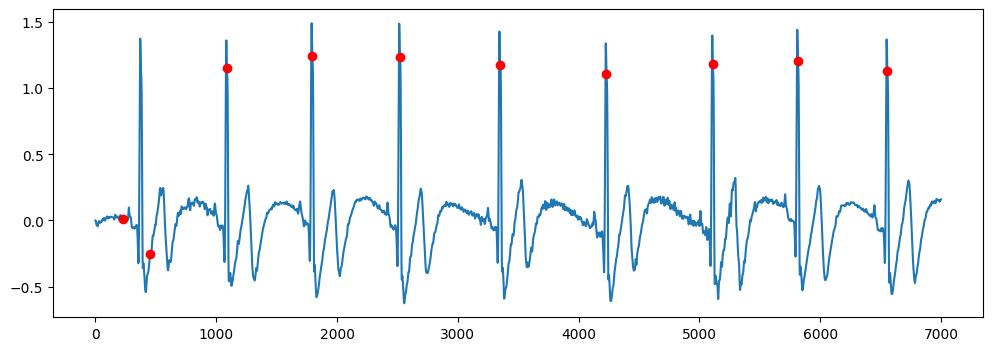

In [79]:
# detect R-peaks
from ecgdetectors import Detectors
detectors = Detectors(fs)

r_peaks_pan = detectors.pan_tompkins_detector(ecg_hln)
r_peaks_pan = np.asarray(r_peaks_pan)

plt.figure(figsize=(12,4))
plt.plot(ecg_hln)
plt.plot(r_peaks_pan,ecg_hln[r_peaks_pan], 'ro')

# **Feature extraction**

In [106]:
# print features 
from hrv import HRV   # to import the module
hrv_class = HRV(fs)
print(r_peaks_pan)
#Number of pairs of succesive NNs that differ by more than 20ms(NN20)
feat_nn20=hrv_class.NN20(r_peaks_pan)
print(f"nn20:{feat_nn20}")
#Number of pairs of succesive NNs that differ by more than 50ms(NN50)
feat_nn50=hrv_class.NN50(r_peaks_pan)
print(f"nn50:{feat_nn50}")
#Root mean square of succesive differences(RMSSD)
feat_rmssd=hrv_class.RMSSD(r_peaks_pan)
print(f"rmssd:{feat_rmssd}")
#Heart-rate feature extraction in BPM(HR)
feat_hr=np.mean(hrv_class.HR(r_peaks_pan))
print(f"HR:{feat_hr}")
#Standard deviation of succesive differences(SDSD)
feat_sdsd=hrv_class.SDSD(r_peaks_pan)
print(f"SDSD:{feat_sdsd}")
#The proportion of NN50 divided by total number of NNs(pNN50)
feat_pnn50=hrv_class.pNN50(r_peaks_pan)
print(f"pNN50:{feat_pnn50}")
#The proportion of NN20 divided by total number of NNs(pNN20)
feat_pnn20=hrv_class.pNN20(r_peaks_pan)
print(f"pNN20:{feat_pnn20}")
#The


[ 227  452 1088 1795 2520 3350 4230 5111 5815 6555]
nn20:7
nn50:6
rmssd:237.13694054581333
HR:70.2733340417372
SDSD:218.5783583168513
pNN50:0.6666666666666666
pNN20:0.7777777777777778


In [97]:
# rpeaks, info = nk.ecg_peaks(ecg, sampling_rate=fs)
# ecg_rate = nk.ecg_rate(r_peaks_pan, sampling_rate=fs, desired_length=len(ecg))

In [96]:
# edr = nk.ecg_rsp(ecg_rate, sampling_rate=fs)
# # Visual comparison
# nk.signal_plot(edr)

In [95]:
# rpeaks, info = nk.ecg_peaks(ecg, sampling_rate=fs)
# ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=fs, desired_length=len(ecg))
# edr = nk.ecg_rsp(ecg_rate, sampling_rate=fs)
# # Visual comparison
# nk.signal_plot(edr)

In [94]:
# resp=chest_data_dict['Resp'][baseline,0]
# resp=resp[10000:10000+ 10*fs]
# t=np.arange(0,resp.size*(1/fs),(1/fs))
# t=t[:ecg.size]

# plt.figure(figsize=(12,4))
# plt.plot(t,resp)
# plt.xlabel('$Time (s)$') 
# plt.ylabel('$ECG$') 